# Forecasting Usage of New York City's 311 Service  
New York City maintains an information and reporting service for city residents that permit them to source information from and report problems to City Government with greater ease.  While the service is an important enhancement to resident life, it imposes an administrative burden on the City as it must receive the requests and reports and refer them to the correct City agency.  A model that can accurately forecast usage of the service would allow the City to serve residents more efficiently.  
<br>
This analysis will search for a model with stronger predictive power than a baseline model.  Potential models will include:
- ARIMA of varying orders
- SARIMA (ARIMA with seasonality) of varying orders
- SARIMAX (SARIMA with exogenous variables) with various regressors
- Prophet, a newer and more flexible model with better handling of seasonality
- GARCH and GARCH-X, if heteroskedasticity is an issue
- Neural networks (LSTM)

In [294]:
# Import packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler
%matplotlib inline
plt.rcParams['axes.prop_cycle'] = cycler(color=['tab:purple'])

from typing import Optional, Tuple, List, Union
import time
import gc
import itertools

from dask import delayed, compute
from dask.distributed import Client, as_completed


# Models
from arch import arch_model
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.make_holidays import make_holidays_df
from scipy.stats import boxcox
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional, Conv1D, Dense, Dropout, Flatten, GRU, Input, LSTM, MaxPooling1D 
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [2]:
# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_info_columns', 100)
pd.set_option('display.max_info_rows', 100)

## Data Preparation
The data sources are:  
- NYC OpenData's 311 call database, which includes calls dating from January 1, 2010
- Daily weather for New York City, retrieved from OpenMeteo's API

The '311_Service_Requests' file is over 20 gigabytes.  To improve loading time, this command only imports relevant features and specifies dtypes for each field.

In [144]:
%%time
# Read in 311 data

df_311_calls  = pd.read_csv('Data/311_Service_Requests_20240430.csv',
                            index_col='Unique Key',
                            usecols = ['Agency','Borough','Complaint Type','Created Date','Incident Zip','Unique Key'],
                            dtype = {'Agency':'category','Borough':'category','Complaint Type':str,'Created Date':str,'Incident Zip':str,'Unique Key':'int64'})

df_311_calls = df_311_calls.rename(columns={'Complaint Type': 'Type', 'Created Date': 'Date', 'Incident Zip': 'Zip'})

CPU times: total: 42.7 s
Wall time: 1min 7s


In [145]:
# Read in NYC zip codes

df_zips = pd.read_csv('Data/uszips/uszips.csv',
                     index_col = 'zip',
                     dtype = {'borough': str, 'zip': str} )

In [ ]:
# Load shapefile of zip codes
#filtered_shapefile_path = 'Data/USA_ZIP_Code_Boundaries/filtered_zip_code_shapefile.shp'
#filtered_zip_codes_gdf = gpd.read_file(filtered_shapefile_path)

##### Drop unusable rows

In [146]:
print(f'Initial items: {len(df_311_calls):,.0f}')

Initial items: 36,217,243


In [147]:
# Drop rows with no useable location data
no_loc = df_311_calls['Zip'].isna() #& df_311['Latitude'].isna()
df_311_calls = df_311_calls[~no_loc]
print(f'Rows with locations: {len(df_311_calls):,.0f}')

Rows with locations: 34,682,301


In [148]:
%%time
# Convert date columns to datetime, dropping time component and dropping dates after March 31, 2024
date_format = '%m/%d/%Y %I:%M:%S %p'
df_311_calls['Date'] = pd.to_datetime(df_311_calls['Date'], format=date_format).values.astype('datetime64[D]')
df_311_calls = df_311_calls[df_311_calls['Date'] < pd.Timestamp('2024-04-01')]
print(f'Rows in the date range: {len(df_311_calls):,.0f}')

Rows in the date range: 34,435,921
CPU times: total: 37.9 s
Wall time: 54.2 s


In [149]:
# Convert NaN values in 'Incident Zip' to 'empty', to simplify further processing
df_311_calls['Zip'] = df_311_calls['Zip'].fillna('empty')
df_311_calls.isna().sum()

# Clean up ZIP codes by removing '-####' if present
df_311_calls['Zip'] = df_311_calls['Zip'].str.replace(r'-\d{4}$', '', regex=True)

# Drop all rows with zip codes not in NYC
df_311_calls = df_311_calls[df_311_calls['Zip'].isin(df_zips.index)]
print(f'Rows in NYC: {len(df_311_calls):,.0f}')

Rows in NYC: 34,388,549


In [150]:
# Fill in latitude and longitude when a zip code is available

# Latitude and longitude from US Zip Code file
#zip_to_lat = df_zip['lat'].to_dict()
#zip_to_lng = df_zip['lng'].to_dict()

# Fill in missing latitude and longitude using the mapping, but only if values don't already exist
#df_311.loc[df_311['Latitude'].isna(), 'Latitude'] = df_311['Zip'].map(zip_to_lat)
#df_311.loc[df_311['Longitude'].isna(), 'Longitude'] = df_311['Zip'].map(zip_to_lng)

##### Consolidate Agencies and Types

In [151]:
# Consolidate agencies, replacing minor agencies with 'Other'
agency_dict = {
    'NYPD': 'Police',
    'HPD': 'Housing',
    'DSNY': 'Sanitation',
    'DOT': 'Transportation',
    'DEP': 'Environment',
    'DOB': 'Buildings',
    'DPR': 'Parks',
    'DOMHM': 'Health',
    'DOF': 'Finance',
    'TLC': 'Taxi',
    'DHS': 'Homeless',
    'DCA': 'Consumer',
    'DEPARTMENT OF CONSUMER AND WORKER PROTECTION': 'Consumer',
    'HRA': 'Human Resources',
}

df_311_calls['Agency'] = df_311_calls['Agency'].map(agency_dict).fillna('Other')

In [152]:
# Convert all line items to lowercase
df_311_calls['Type'] = df_311_calls['Type'].str.lower()

In [153]:
# Convert complaint types to fewer categories
complaint_dict = {
    'noise - residential': 'Noise','illegal parking': 'Vehicle','heat/hot water': 'Resident Utility','blocked driveway': 'Vehicle','street condition': 'Street Condition','noise - street/sidewalk': 'Noise',
    'street light condition': 'Traffic Device','request large bulky item collection': 'Item Pickup','plumbing': 'Resident Utility','heating': 'Resident Utility','water system': 'Resident Utility',
    'unsanitary condition': 'Sanitation','noise': 'Noise','general construction/plumbing': 'Resident Utility','traffic signal condition': 'Traffic Device','noise - commercial': 'Noise',
    'paint/plaster': 'Buildings','noise - vehicle': 'Noise','general construction': 'Construction','sewer': 'Sewer','damaged tree': 'Tree','rodent': 'Sanitation','dirty conditions': 'Sanitation',
    'electric': 'Resident Utility','derelict vehicles': 'Vehicle','sanitation condition': 'Sanitation','door/window': 'Buildings','paint - plaster': 'Buildings','sidewalk condition': 'Street Condition',
    'water leak': 'Resident Utility','building/use': 'Buildings','missed collection (all materials)': 'Sanitation','literature request': 'Other','consumer complaint': 'Consumer','general': 'Other',
    'homeless person assistance': 'Social Services','nonconst': 'Other','abandoned vehicle': 'Vehicle','new tree request': 'Tree','flooring/stairs': 'Buildings','graffiti': 'Quality of Life',
    'overgrown tree/branches': 'Tree','non-emergency police matter': 'Police','derelict vehicle': 'Vehicle','maintenance or facility': 'Other','taxi complaint': 'Taxi','appliance': 'Buildings',
    'elevator': 'Buildings','broken muni meter': 'Parking','missed collection': 'Sanitation','noise - helicopter': 'Noise','root/sewer/sidewalk condition': 'Street Condition','food establishment': 'Vendors',
    'for hire vehicle complaint': 'Taxi','dirty condition': 'Sanitation','air quality': 'Environmental','benefit card replacement': 'Social Services','encampment': 'Social Services',
    'dof property - reduction issue': 'Finance','lead': 'Public Health','safety': 'Other','street sign - damaged': 'Traffic Device','illegal fireworks': 'Quality of Life','snow': 'Snow',
    'electronics waste appointment': 'Item Pickup','scrie': 'Housing','dead/dying tree': 'Tree','illegal dumping': 'Sanitation','broken parking meter': 'Parking','other enforcement': 'Police',
    'dof parking - payment issue': 'Finance','indoor air quality': 'Buildings','noise - park': 'Noise','curb condition': 'Street Condition','street sign - missing': 'Traffic Device',
    'noncompliance with phased reopening': 'Public Health','dof property - owner issue': 'Finance','traffic': 'Traffic Device','dof property - request copy': 'Finance','highway condition': 'Street Condition',
    'dead tree': 'Tree','emergency response team (ert)': 'Buildings','special projects inspection team (spit)': 'Construction','water conservation': 'Parks and Rec','dof property - payment issue': 'Finance',
    'hpd literature request': 'Housing','animal abuse': 'Animal','housing - low income senior': 'Housing','drug activity': 'Police','vending': 'Quality of Life','electrical': 'Resident Utility',
    'illegal tree damage': 'Tree','dhs advantage - tenant': 'Housing','food poisoning': 'Public Health','street sign - dangling': 'Traffic Device','violation of park rules': 'Parks and Rec',
    'homeless encampment': 'Social Services','smoking': 'Public Health','animal-abuse': 'Animal','animal in a park': 'Animal','hazardous materials': 'Environmental','obstruction': 'Vehicle',
    'construction': 'Construction','lost property': 'Other','litter basket / request': 'Sanitation','boilers': 'Resident Utility','construction safety enforcement': 'Construction',
    'dhs advantage -landlord/broker': 'Housing','unsanitary animal pvt property': 'Animal','drinking': 'Social Services','residential disposal complaint': 'Sanitation','standing water': 'Environmental',
    'electronics waste': 'Item Pickup','panhandling': 'Social Services','dca / doh new license application request': 'Vendors','asbestos': 'Buildings','dead animal': 'Animal',
    'dof property - update account': 'Finance','outdoor dining': 'Vendors','best/site safety': 'Construction','street sweeping complaint': 'Street Condition','water quality': 'Resident Utility',
    'vendor enforcement': 'Vendors','real time enforcement': 'Buildings','housing options': 'Housing','bus stop shelter complaint': 'Social Services','industrial waste': 'Environmental',
    'bike/roller/skate chronic': 'Quality of Life','mobile food vendor': 'Vendors','overflowing litter baskets': 'Sanitation','derelict bicycle': 'Vehicle','noise survey': 'Noise','non-residential heat': 'Buildings',
    'miscellaneous categories': 'Other','homeless street condition': 'Social Services','noise - house of worship': 'Noise','taxi report': 'Taxi','traffic/illegal parking': 'Vehicle','unleashed dog': 'Animal',
    'indoor sewage': 'Resident Utility','outside building': 'Other','snow or ice': 'Snow','dof parking - request status': 'Finance','unsanitary pigeon condition': 'Animal','sweeping/missed': 'Street Condition',
    'dof parking - request copy': 'Finance','recycling enforcement': 'Sanitation','dpr internal': 'Parks and Rec','urinating in public': 'Social Services','litter basket request': 'Sanitation',
    'day care': 'Social Services','illegal posting': 'Quality of Life','borough office': 'Other','sanitation worker or vehicle complaint': 'Sanitation','vaccine mandate non-compliance': 'Public Health',
    'covid-19 non-essential construction': 'Construction','building marshals office': 'Buildings','commercial disposal complaint': 'Sanitation','dof parking - tax exemption': 'Finance',
    'bridge condition': 'Street Condition','sustainability enforcement': 'Sanitation','taxi compliment': 'Taxi','elder abuse': 'Social Services','sweeping/missed-inadequate': 'Street Condition',
    'disorderly youth': 'Social Services','abandoned bike': 'Vehicle','mold': 'Buildings','dumpster complaint': 'Sanitation','illegal animal kept as pet': 'Animal','mosquitoes': 'Environmental',
    'for hire vehicle report': 'Taxi','drie': 'Housing','found property': 'Other','home delivered meal - missed delivery': 'Social Services','litter basket complaint': 'Sanitation',
    'construction lead dust': 'Environmental','mass gathering complaint': 'Quality of Life','cranes and derricks': 'Construction','dof property - rpie issue': 'Finance','posting advertisement': 'Quality of Life',
    'home repair': 'Buildings','harboring bees/wasps': 'Animal','scaffold safety': 'Construction','adopt-a-basket': 'Sanitation','senior center complaint': 'Social Services','plant': 'Other',
    'window guard': 'Buildings','sewer maintenance': 'Sewer','snow removal': 'Snow','sweeping/inadequate': 'Street Condition',"alzheimer's care": 'Social Services','beach/pool/sauna complaint': 'Parks and Rec',
    'city vehicle placard complaint': 'Other','drinking water': 'Resident Utility','collection truck noise': 'Sanitation','question': 'Other','facades': 'Buildings','private or charter school reopening': 'Public Health',
    'dof property - property value': 'Finance','dof parking - dmv clearance': 'Finance','request xmas tree collection': 'Item Pickup','poison ivy': 'Environmental','oem disabled vehicle': 'Vehicle',
    'uprooted stump': 'Tree','wood pile remaining': 'Construction','face covering violation': 'Public Health','tattooing': 'Other','heap assistance': 'Resident Utility','highway sign - damaged': 'Traffic Device',
    'quality of life': 'Quality of Life','utility program': 'Resident Utility','executive inspections': 'Buildings','forms': 'Other','dhs advantage - third party': 'Public Health','unsanitary animal facility': 'Vendors',
    'green taxi complaint': 'Taxi','dof property - city rebate': 'Finance','forensic engineering': 'Buildings','weatherization': 'Buildings','pet shop': 'Vendors','animal facility - no permit': 'Vendors',
    'special natural area district (snad)': 'Parks and Rec','municipal parking facility': 'Parking','home delivered meal complaint': 'Social Services','illegal animal sold': 'Animal',
    'seasonal collection': 'Item Pickup','dep street condition': 'Street Condition','stalled sites': 'Other','advocate-personal exemptions': 'Finance','highway sign - missing': 'Traffic Device',
    'ahv inspection unit': 'Vendors','e-scooter': 'Quality of Life','public toilet': 'Parks and Rec','eviction': 'Housing','fatf': 'Finance','dof parking - address update': 'Parking',
    'advocate-prop refunds/credits': 'Finance','water maintenance': 'Resident Utility','highway sign - dangling': 'Traffic Device','parking card': 'Parking','taxpayer advocate inquiry': 'Finance',
    'summer camp': 'Parks and Rec','special operations': 'Quality of Life','incorrect data': 'Other','bereavement support group': 'Social Services','advocate - other': 'Social Services','lifeguard': 'Parks and Rec',
    'squeegee': 'Quality of Life','x-ray machine/equipment': 'Other','home care provider complaint': 'Social Services','case management agency complaint': 'Social Services','atf': 'Police',
    'private school vaccine mandate non-compliance': 'Public Health','overflowing recycling baskets': 'Sanitation','comments': 'Other','cooling tower': 'Buildings','recycling basket complaint': 'Sanitation',
    'calorie labeling': 'Vendors','legal services provider complaint': 'Social Services','health': 'Public Health','radioactive material': 'Environmental','dhs income savings requirement': 'Housing',
    'institution disposal complaint': 'Sanitation','water drainage': 'Environmental','green taxi report': 'Taxi','peeling paint': 'Buildings','tunnel condition': 'Street Condition',
    'building drinking water tank': 'Buildings',
}    

In [154]:
df_311_calls['Type'] = df_311_calls['Type'].map(complaint_dict).fillna('Other')

#### Visualize Distributions

In [155]:
# Clean Borough values for charting
df_311_calls['Borough'] = df_311_calls['Borough'].str.title()

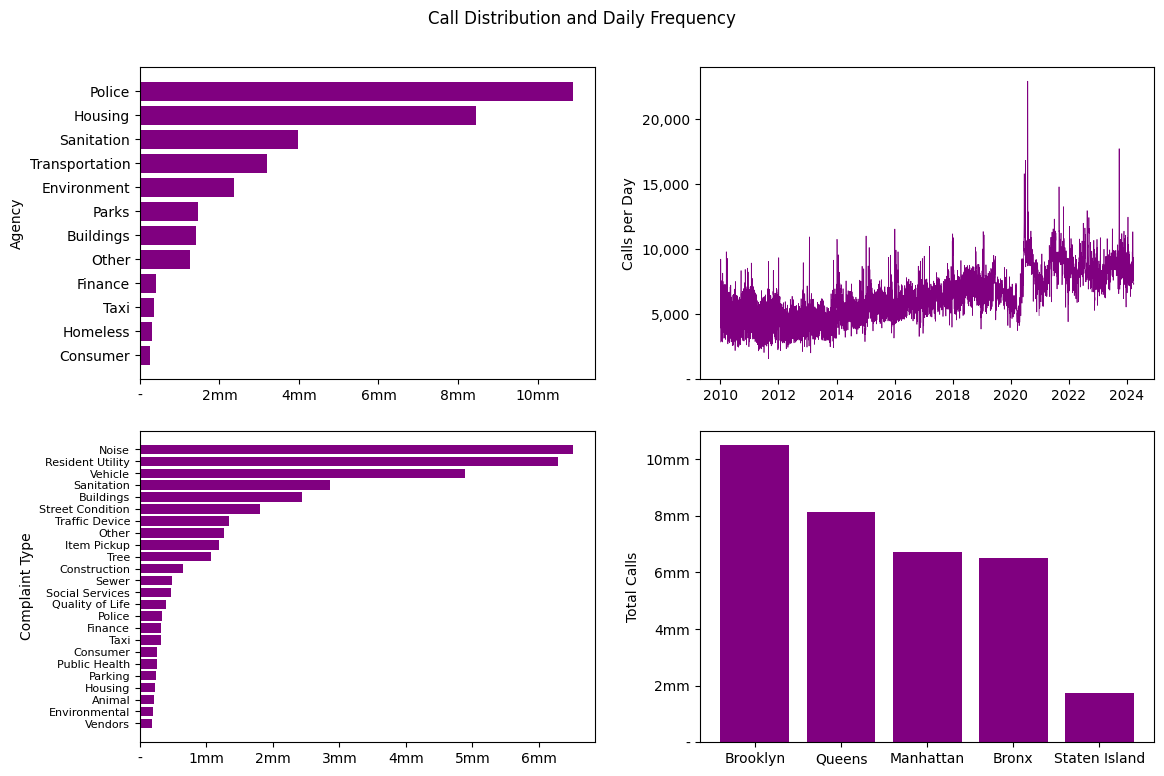

In [156]:
# Visualize call data
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12,8))
fig.suptitle('Call Distribution and Daily Frequency')
ax1.barh(y = df_311_calls['Agency'].value_counts().sort_values(ascending=True).index[1:], width = df_311_calls['Agency'].value_counts().sort_values(ascending=True)[1:], color='purple')
ax1.set_xticks([0,2000000,4000000,6000000,8000000,10000000])
ax1.set_xticklabels(['-','2mm','4mm','6mm','8mm','10mm'])
ax1.set_ylabel('Agency')
ax2.plot(df_311_calls['Date'].value_counts().sort_index(), linewidth=0.5, color='purple')
ax2.set_yticks([0,5000,10000,15000,20000])
ax2.set_yticklabels(['-','5,000','10,000','15,000','20,000'])
ax2.set_ylabel('Calls per Day')
ax3.barh(y= df_311_calls['Type'].value_counts().sort_values(ascending=True).index[2:], width = df_311_calls['Type'].value_counts().sort_values(ascending=True)[2:], color='purple')
ax3.tick_params(axis='y', labelsize=8)
ax3.set_xticks([0,1000000,2000000,3000000,4000000,5000000,6000000])
ax3.set_xticklabels(['-','1mm','2mm','3mm','4mm','5mm','6mm'])
ax3.set_ylabel('Complaint Type')
ax4.bar(x=df_311_calls['Borough'].value_counts().sort_values(ascending=False)[:-1].index, height=df_311_calls['Borough'].value_counts().sort_values(ascending=False)[:-1], color='purple')
ax4.set_yticks([0,2000000,4000000,6000000,8000000,10000000])
ax4.set_yticklabels(['-','2mm','4mm','6mm','8mm','10mm'])
ax4.set_ylabel('Total Calls')
plt.tight_layout(pad=2.0)
plt.show()

### Weather

In [157]:
# Read in NYC weather data, and format
df_weather = pd.read_csv('Data/NYC_weather_data.csv')
df_weather.drop('Unnamed: 0', axis=1, inplace=True)
df_weather['date'] = pd.to_datetime(df_weather['date']).values.astype('datetime64[D]')
df_weather.set_index('date',inplace=True)
df_weather.drop_duplicates(inplace=True)
df_weather = df_weather[df_weather.index < pd.Timestamp('2024-04-01')]
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5204 entries, 2010-01-01 to 2024-03-31
Data columns (total 7 columns):
 #   Column               Dtype  
---  ------               -----  
 0   temperature_2m_max   float64
 1   temperature_2m_min   float64
 2   temperature_2m_mean  float64
 3   daylight_duration    float64
 4   rain_sum             float64
 5   snowfall_sum         float64
 6   wind_speed_10m_max   float64
dtypes: float64(7)
memory usage: 325.2 KB


#### Visualize

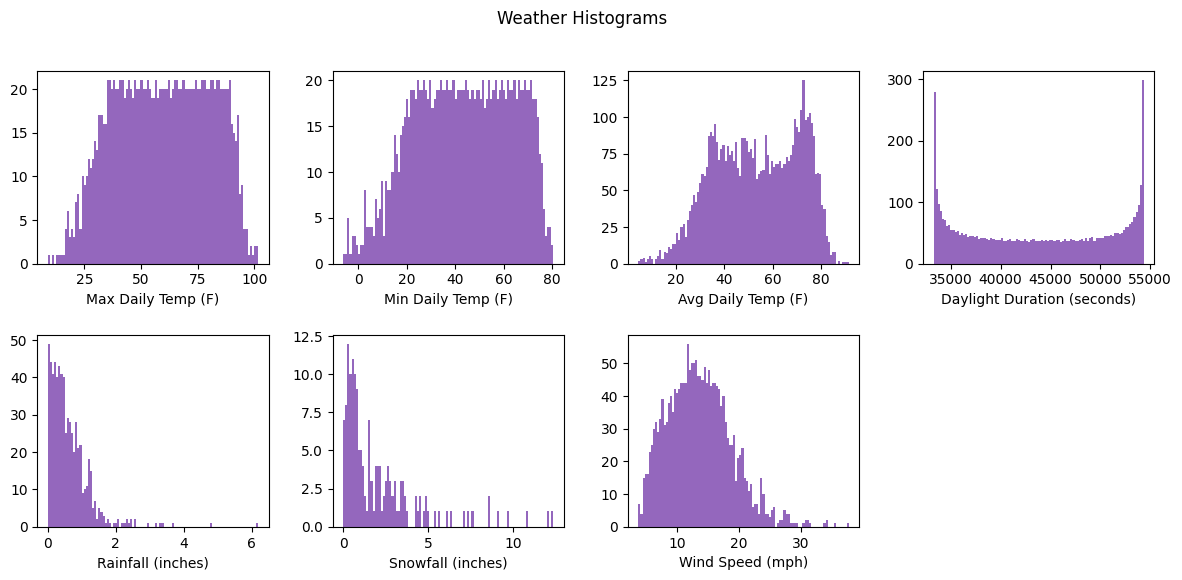

In [158]:
# Visualize weather data
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(12,6))
fig.suptitle('Weather Histograms')
ax1.hist(df_weather['temperature_2m_max'].value_counts().index, bins=100)
ax1.set_xlabel('Max Daily Temp (F)')
ax2.hist(df_weather['temperature_2m_min'].value_counts().index, bins=100)
ax2.set_xlabel('Min Daily Temp (F)')
ax3.hist(df_weather['temperature_2m_mean'].value_counts().index, bins=100)
ax3.set_xlabel('Avg Daily Temp (F)')
ax4.hist(df_weather['daylight_duration'].value_counts().index, bins=100)
ax4.set_xlabel('Daylight Duration (seconds)')
ax5.hist(df_weather['rain_sum'].value_counts().index, bins=100)
ax5.set_xlabel('Rainfall (inches)')
ax6.hist(df_weather['snowfall_sum'].value_counts().index, bins=100)
ax6.set_xlabel('Snowfall (inches)')
ax7.hist(df_weather['wind_speed_10m_max'].value_counts().index, bins=100)
ax7.set_xlabel('Wind Speed (mph)')
ax8.axis('off')
plt.tight_layout(pad=2.0)
plt.show;

#### Scaling
- Rainfall, snowfall and wind speed: Box-Cox transformation, addresses right-skewed distributions
- Temperatures - Temperatures are normally distributed when holding seasonality constant.  Seasonal decompose first, then standard scale, then seasonal recompose
- Daylight Duration - Minmax scaling

In [159]:
# Scaling functions for weather data

# log transform with a small constant
def log_transform(series, constant=1e-6):
    return np.log(series + constant)

# Helper function to apply Box-Cox transformation
def boxcox_transform(series):
    series_nonzero = series + 1e-6  # Add small constant to avoid zero values
    transformed_data, _ = boxcox(series_nonzero)
    return pd.Series(transformed_data, index=series.index)

# Seasonal decompose and recompose function
def decompose_and_scale(series, period=365):
    series = series.dropna()  # Drop NaNs if any
    decomposition = seasonal_decompose(series, model='additive', period=period)
    seasonal = decomposition.seasonal
    adjusted_series = series - seasonal  # Adjust the original series by removing the seasonal component

    scaler = StandardScaler()
    scaled_series = scaler.fit_transform(adjusted_series.values.reshape(-1, 1))

    scaled_series_full = pd.Series(scaled_series.flatten(), index=adjusted_series.index)
    scaled_series_full = scaled_series_full.reindex(series.index).bfill().ffill()

    return scaled_series_full


In [160]:
# Applying transformations

# Temperature columns: seasonal decompose, scale, recompose
df_weather['temperature_2m_max_scaled'] = decompose_and_scale(df_weather['temperature_2m_max'])
df_weather['temperature_2m_min_scaled'] = decompose_and_scale(df_weather['temperature_2m_min'])
df_weather['temperature_2m_mean_scaled'] = decompose_and_scale(df_weather['temperature_2m_mean'])

# Daylight duration: MinMax scale
df_weather['daylight_duration_scaled'] = MinMaxScaler().fit_transform(df_weather['daylight_duration'].values.reshape(-1, 1))

# Rainfall and Snowfall: Log transform with small constant
df_weather['rain_sum_log'] = boxcox_transform(df_weather['rain_sum'])
df_weather['snowfall_sum_log'] = boxcox_transform(df_weather['snowfall_sum'])

# Wind speed: Log transform
df_weather['wind_speed_10m_max_log'] = boxcox_transform(df_weather['wind_speed_10m_max'])

df_weather.drop(columns=['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean',
                         'daylight_duration', 'rain_sum', 'snowfall_sum', 'wind_speed_10m_max'], inplace=True)

df_weather.rename(columns={
    'temperature_2m_max_scaled': 'temperature_2m_max',
    'temperature_2m_min_scaled': 'temperature_2m_min',
    'temperature_2m_mean_scaled': 'temperature_2m_mean',
    'daylight_duration_scaled': 'daylight_duration',
    'rain_sum_log': 'rain_sum',
    'snowfall_sum_log': 'snowfall_sum',
    'wind_speed_10m_max_log': 'wind_speed_10m_max'
}, inplace=True)

## Modeling
- Perform Baseline model, 1 day shift (equal to ARIMA(0,1,0))
- Step up to ARIMA model to see if performance can be improved
- Search for seasonality (weekly and annually) and apply SARIMA if found
- SARIMA can only handle one dimension of seasonality, consider TBATs for more than one period
  

In [161]:
# Identify future target columns
target_cols = ['Agency', 'Type', 'Zip', 'Borough']

# Create Master dataset to use for modeling
df_311_dates_drop = df_311_calls.drop(columns=target_cols, axis=1)
time_series = df_311_dates_drop.groupby('Date').size().reset_index(name='Count')
time_series.set_index('Date', inplace=True)

# Dummy for COVID period
lockdown1 = pd.date_range(start='2020-03-21', end='2020-06-06', inclusive='both')
lockdown2 = pd.date_range(start='2021-07-09', end='2021-10-27', inclusive='both')
lockdown3 = pd.date_range(start='2021-02-13', end='2021-02-17', inclusive='both')
lockdown4 = pd.date_range(start='2021-05-28', end='2021-06-10', inclusive='both')
lockdowns = lockdown1.union(lockdown2).union(lockdown3).union(lockdown4)

time_series['covid'] = time_series.index.isin(lockdowns) * 1
time_series['winter'] = (time_series.index.month <= 2) * 1
time_series['weekend'] = (time_series.index.dayofweek >= 5) * 1
time_series['311_app'] = (time_series.index >= pd.Timestamp('2013-03-19')) * 1

time_series = pd.concat([time_series, df_weather], axis=1)

In [162]:
# Interpolate NYC population using US Census estimates
population_data = {
    'date': pd.to_datetime(['2010-01-01', '2010-07-01', '2011-07-01', '2012-07-01', '2013-07-01', '2014-07-01',
                            '2015-07-01', '2016-07-01', '2017-07-01', '2018-07-01', '2019-07-01',
                            '2020-04-01', '2020-07-01', '2021-07-01', '2022-07-01', '2023-07-01', '2024-03-31']),
    'population': [8175133, 8190209, 8251281, 8312676, 8374527, 8436839, 8499614, 8562857, 8626570, 8690757, 8755421, 8804199, 8740292, 8462216, 8335798, 8258035, 8200257]
}

# Create DataFrame
population_df = pd.DataFrame(population_data)

# Set the date as index
population_df.set_index('date', inplace=True)

# Generate a date range from 2010-01-01 to 2024-03-31
date_range = pd.date_range(start='2010-01-01', end='2024-03-31', freq='D')

# Reindex the population data to the full date range, using interpolation to fill in the gaps
population_daily_df = population_df.reindex(date_range)
population_daily_df['population'] = population_daily_df['population'].interpolate(method='linear')

# Scale population numbers
population_daily_df['population'] = MinMaxScaler().fit_transform(population_daily_df['population'].values.reshape(-1, 1))

time_series = pd.concat([time_series, population_daily_df], axis=1)
time_series = time_series.asfreq('D')

In [163]:
test_size = 731         # two years plus one day

split_point = len(time_series) - test_size
train_df = time_series.iloc[:split_point]
test_df = time_series.iloc[split_point:]

<br>

***Rolling Forecast function***: There is no native function to perform a rolling forecast over a time series.  Because this notebook will perform rolling forecasts repeatedly, a helper function will help to make the notebook more readable, and to avoid repetition.  The function will be applicable to any ARIMA or SARIMA forecasts.  It will always need testing and training sets and a pdq tuple as arguments.  For SARIMA models, it will also need a PDQm tuple.  For SARIMAX models, it will also need exogenous training and testing sets.  The function assumes a maximum of 50 iterations, but can be reset higher by keyword argument.  The function returns MAPE, training predictions and future predictions, and optionally, the last model object for reporting purposes.  
<br>
***Plot Forecast function***: The forecast will be plotted repeatedly.  This function makes the notebook more readable and allows parameters to be changed one time to apply to all charts

In [164]:
def rolling_forecast(train_series: pd.Series,
                     test_series: pd.Series,
                     pdq: Tuple[int, int, int],
                     seasonal_pdq: Optional[Tuple[int, int, int, int]] = None,
                     exog_train: Optional[pd.DataFrame] = None,
                     exog_test: Optional[pd.DataFrame] = None,
                     maxiter: int = 50,
                     return_last_model: bool = False,
                     start_params: Optional[List[float]] = None) -> Union[Tuple[float, pd.Series, List[float]], Tuple[float, pd.Series, List[float], SARIMAX]]:

    history = list(train_series)
    exog_history = exog_train.values.tolist() if exog_train is not None else None
    predictions = []
    total_steps = len(test_series)
    start_time = time.time()

    train_pred = None
    
    for t in range(total_steps):
        if exog_history is not None:
            model = SARIMAX(history, exog=exog_history, order=pdq, seasonal_order=seasonal_pdq)
            model_fit = model.fit(disp=False, maxiter=maxiter, start_params=start_params)
            yhat = model_fit.forecast(exog=exog_test.iloc[t:t+1])[0]
            exog_history.append(exog_test.iloc[t].values)
            if t == 0:
                train_pred = model_fit.predict(start=0, end=len(train_series) - 1, exog=exog_train)
        else:
            model = SARIMAX(history, order=pdq, seasonal_order=seasonal_pdq)
            model_fit = model.fit(disp=False, maxiter=maxiter, start_params=start_params)
            yhat = model_fit.forecast()[0]
            if t == 0:
                train_pred = model_fit.predict(start=0, end=len(train_series) - 1)
        predictions.append(yhat)
        history.append(test_series.iloc[t])

        # Do not grow the training size!
        if len(history) > len(train_series):
            history.pop(0)
            if exog_history is not None:
                exog_history.pop(0)

        gc.collect()

        if (t + 1) % 100 == 0 or (t + 1) == total_steps:
            elapsed_time = time.time() - start_time
            print(f"Progress: {t + 1} out of {total_steps} steps completed in {elapsed_time} seconds")
            start_time = time.time()

    mape = mean_absolute_percentage_error(test_series, predictions)

    if return_last_model:
        return mape, train_pred, predictions, model_fit
    return mape, train_pred, predictions

In [165]:
def plot_forecast(train_series: pd.Series,
                  test_series: pd.Series,
                  train_pred: pd.Series,
                  test_pred: list,
                  title: str) -> None:
    fig, ax = plt.subplots(figsize=(13, 3))
    ax.plot(train_series.index, train_pred, label='Training Prediction', color='blue', alpha=0.6)
    ax.plot(test_series.index, test_pred, label='Test Prediction', color='orange', alpha=0.6)
    ax.scatter(train_series.index, train_series,
               alpha=0.3, label='Training Data', color='blue', edgecolors='black', linewidths=.5, s=10)
    ax.scatter(test_series.index, test_series,
               alpha=0.3, label='Testing Data', color='orange', edgecolors='black', linewidths=.5, s=10)

    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.title(f'{title}')
    plt.legend()
    plt.show()

### Choosing a Baseline Model
Three different models could serve as a baseline for a time series problem.  Each is assessed below:
- First order regressive, or AR(1)
- Random walk
- First order moving average, or MA(1)  

##### AR(1) Model

In [25]:
# ARIMA (1, 0, 0)
arima_100_mape, arima_100_train_pred, arima_100_predictions, arima_100_model = rolling_forecast(train_df['Count'], test_df['Count'],
                                                                                                (1, 0, 0), return_last_model=True)
print(f'MAPE: {arima_100_mape:.4f}')

Progress: 100 out of 731 steps completed in 10.881311893463135 seconds
Progress: 200 out of 731 steps completed in 10.879321098327637 seconds
Progress: 300 out of 731 steps completed in 10.690449476242065 seconds
Progress: 400 out of 731 steps completed in 10.700856685638428 seconds
Progress: 500 out of 731 steps completed in 11.224525690078735 seconds
Progress: 600 out of 731 steps completed in 11.31495213508606 seconds
Progress: 700 out of 731 steps completed in 11.226804256439209 seconds
Progress: 731 out of 731 steps completed in 3.3915534019470215 seconds
MAPE: 0.0898


In [26]:
arima_100_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4473
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -37793.712
Date:                Fri, 24 May 2024   AIC                          75591.424
Time:                        13:19:02   BIC                          75604.235
Sample:                             0   HQIC                         75595.940
                               - 4473                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9871      0.002    422.332      0.000       0.983       0.992
sigma2      1.277e+06   1.31e+04     97.860      0.000    1.25e+06     1.3e+06
===================================================================================
Ljung-Box (L1) (Q):                  52.54   Jarque-Bera (JB):              9518.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.96
Prob(H) (two-sided):                  0.19   Kurtosis:                         9.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

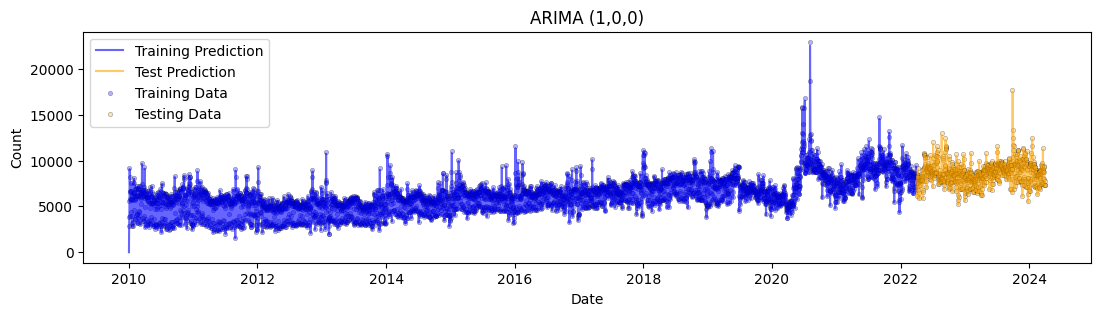

In [27]:
plot_forecast(train_df['Count'], test_df['Count'], arima_100_train_pred, arima_100_predictions, "ARIMA (1,0,0)")

##### Random Walk

In [28]:
%%time
# ARIMA (0, 1, 0)
arima_010_mape, arima_010_train_pred, arima_010_predictions, arima_010_model = rolling_forecast(train_df['Count'], test_df['Count'],
                                                                                                (0, 1, 0), return_last_model=True)
print(f'MAPE: {arima_010_mape:.4f}')

C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Progress: 100 out of 731 steps completed in 10.221444368362427 seconds
Progress: 200 out of 731 steps completed in 9.874231338500977 seconds
Progress: 300 out of 731 steps completed in 10.143600940704346 seconds
Progress: 400 out of 731 steps completed in 10.274015426635742 seconds
Progress: 500 out of 731 steps completed in 10.213366270065308 seconds
Progress: 600 out of 731 steps completed in 10.0726637840271 seconds
Progress: 700 out of 731 steps completed in 9.971810102462769 seconds
Progress: 731 out of 731 steps completed in 3.078022003173828 seconds
MAPE: 0.0908
CPU times: total: 51.1 s
Wall time: 1min 13s


In [29]:
arima_010_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4473
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -37797.959
Date:                Fri, 24 May 2024   AIC                          75597.919
Time:                        13:20:16   BIC                          75604.324
Sample:                             0   HQIC                         75600.176
                               - 4473                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.285e+06    1.3e+04     99.033      0.000    1.26e+06    1.31e+06
===================================================================================
Ljung-Box (L1) (Q):                  52.98   Jarque-Bera (JB):              9188.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.94
Prob(H) (two-sided):                  0.15   Kurtosis:                         9.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

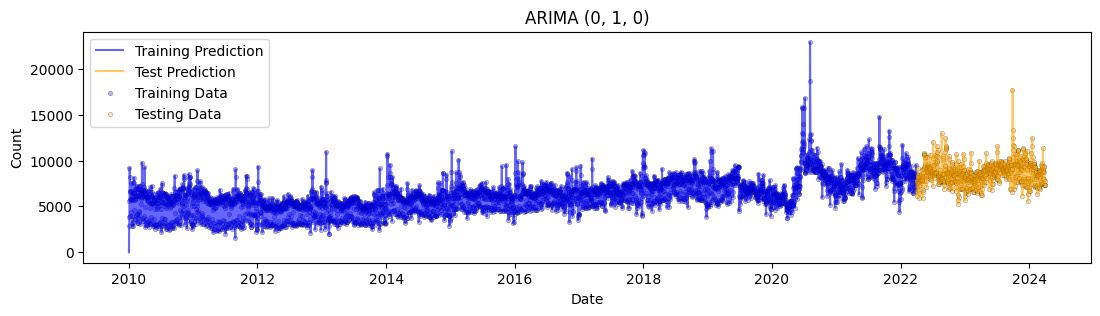

In [30]:
plot_forecast(train_df['Count'], test_df['Count'], arima_010_train_pred, arima_010_predictions, "ARIMA (0, 1, 0)")

<br>

##### MA(1) Model

In [31]:
%%time
# ARIMA (0, 0, 1)
arima_001_mape, arima_001_train_pred, arima_001_predictions, arima_001_model = rolling_forecast(train_df['Count'], test_df['Count'],
                                                                                                (0, 0, 1), return_last_model=True)
print(f'MAPE: {arima_001_mape:.4f}')

Progress: 100 out of 731 steps completed in 34.841376304626465 seconds
Progress: 200 out of 731 steps completed in 34.20689797401428 seconds
Progress: 300 out of 731 steps completed in 34.851752519607544 seconds
Progress: 400 out of 731 steps completed in 34.71914839744568 seconds
Progress: 500 out of 731 steps completed in 35.46377229690552 seconds
Progress: 600 out of 731 steps completed in 35.90241098403931 seconds
Progress: 700 out of 731 steps completed in 36.073630571365356 seconds
Progress: 731 out of 731 steps completed in 11.169529676437378 seconds
MAPE: 0.5229
CPU times: total: 6min 2s
Wall time: 4min 17s


In [32]:
arima_001_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4473
Model:               SARIMAX(0, 0, 1)   Log Likelihood              -43336.086
Date:                Fri, 24 May 2024   AIC                          86676.173
Time:                        13:24:33   BIC                          86688.984
Sample:                             0   HQIC                         86680.688
                               - 4473                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.9099      0.006    154.764      0.000       0.898       0.921
sigma2      1.523e+07   3.08e-11   4.94e+17      0.000    1.52e+07    1.52e+07
===================================================================================
Ljung-Box (L1) (Q):                 156.93   Jarque-Bera (JB):              1868.72
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                             0.66
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

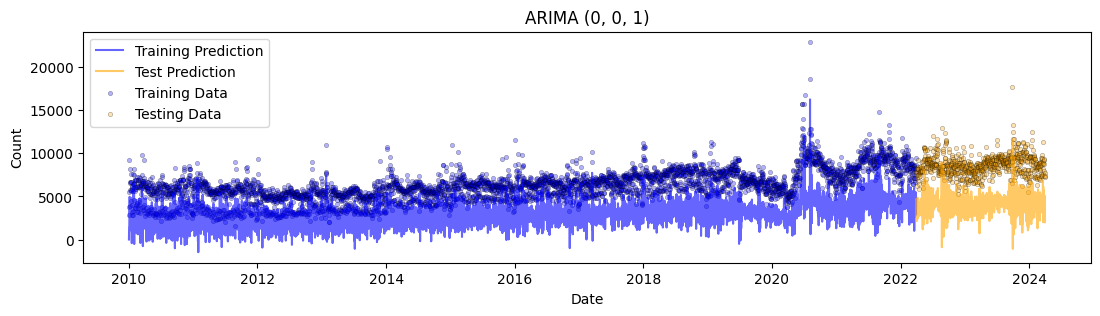

In [33]:
plot_forecast(train_df['Count'], test_df['Count'], arima_001_train_pred, arima_001_predictions, "ARIMA (0, 0, 1)")

<br>

**AR(1) is the baseline**: AR(1) and Random Walk both have 9.1% average percentage errors.  AR(1) is slightly lower, so this will serve as the comparison going forward.

<br>

### First Simple Model: ARIMA
ARIMA will look for autoregressive and moving average terms that will lead to improvements against the baseline.  ARIMA models are applied to "stationary" data sets.  The Augmented Dickey-Fuller test will test to determine whether this data is stationary.  Large negative statistics, and p-values under 0.05, imply that the data *is* stationary. 

In [166]:
result = adfuller(time_series['Count'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -2.5208859123946588
p-value: 0.11047490316084208


<b><span style="color:red">Not stationary</span></b>.  Because the p-value is not less than 0.05, the data is not stationary and must be transformed.  The first transformation will use the one-day difference.

In [167]:
# Transform the data by taking the one-day difference
time_series['Count_diff'] = time_series['Count'].diff().dropna()
result_diff = adfuller(time_series['Count_diff'].dropna())
print(f'ADF Statistic (1st diff): {result_diff[0]}')
print(f'p-value (1st diff): {result_diff[1]}')

ADF Statistic (1st diff): -21.56754139806522
p-value (1st diff): 0.0


<b><span style="color:#15B01A">Stationary</span></b>.  The data is now stationary so the future 'd' term will be 1.  Now, the Autocorrelation Function CF and PACF to look for good p and q terms, and check for seasonality. 

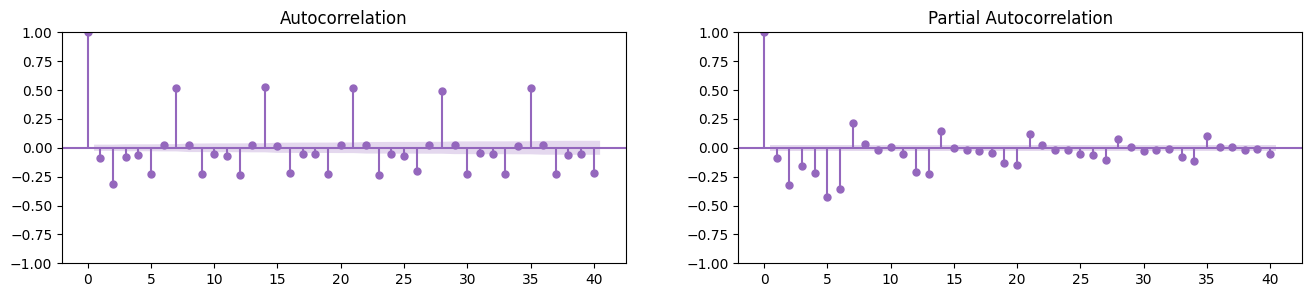

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16, 3))

plot_acf(time_series['Count_diff'].dropna(), lags=40, ax=axes[0])
plot_pacf(time_series['Count_diff'].dropna(), lags=40, ax=axes[1]);

The drop-off after 1 term in each chart suggests that p=1 and q=1 will lead to better results.  However, the oscillation makes it difficult to determine what the right term actually will be.  Notably, the 7-day pattern outside of the confidence interval suggests seasonality.

The simple first model, will use ARIMA (1,1,1), based on visual inspection of the ACF and PACF.  Then a grid search will recommend the best set of 'pdq' to use.

In [37]:
# ARIMA (1, 1, 1)
arima_111_mape, arima_111_train_pred, arima_111_predictions, arima_111_model = rolling_forecast(train_df['Count'], test_df['Count'], (1, 1, 1), return_last_model=True)
print(f'MAPE: {arima_111_mape:.4f}')

Progress: 100 out of 731 steps completed in 47.999796628952026 seconds
Progress: 200 out of 731 steps completed in 46.05063247680664 seconds
Progress: 300 out of 731 steps completed in 48.129666805267334 seconds
Progress: 400 out of 731 steps completed in 47.31652545928955 seconds
Progress: 500 out of 731 steps completed in 48.92163133621216 seconds
Progress: 600 out of 731 steps completed in 45.70543456077576 seconds
Progress: 700 out of 731 steps completed in 47.33484363555908 seconds
Progress: 731 out of 731 steps completed in 15.040703773498535 seconds
MAPE: 0.0832


In [38]:
arima_111_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4473
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -37227.478
Date:                Fri, 24 May 2024   AIC                          74460.956
Time:                        13:30:20   BIC                          74480.173
Sample:                             0   HQIC                         74467.730
                               - 4473                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4773      0.012     40.691      0.000       0.454       0.500
ma.L1         -0.9521      0.004   -239.303      0.000      -0.960      -0.944
sigma2       9.95e+05   9107.749    109.243      0.000    9.77e+05    1.01e+06
===================================================================================
Ljung-Box (L1) (Q):                  43.22   Jarque-Bera (JB):             16691.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                             1.20
Prob(H) (two-sided):                  0.90   Kurtosis:                        12.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

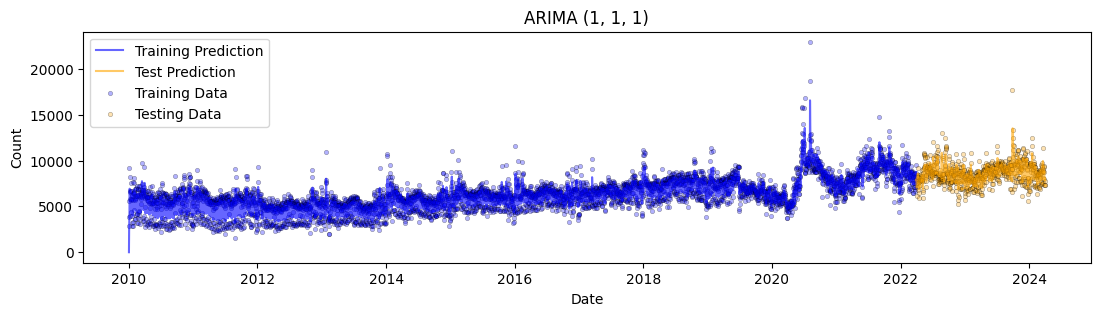

In [39]:
plot_forecast(train_df['Count'], test_df['Count'], arima_111_train_pred, arima_111_predictions, "ARIMA (1, 1, 1)")

<br>

**ARIMA(1, 1, 1) is the new best model**. 8.32% is a substantial improvement over the baseline.  Grid search will look for a better combination.

In [ ]:
%%time
# Grid Search for ARIMA parameters

client = Client('192.168.4.40:8786')

p = q = range(0, 8)
d = [1]
arima_pdq = list(itertools.product(p, d, q))

def fit_arima(train, param):
    try:
        model = ARIMA(train, order=param)
        model_fit = model.fit(method_kwargs={"maxiter": 1000})
        aic = model_fit.aic
        logging.info(f'Successfully fitted ARIMA model with parameters {param}, AIC: {aic:.4f}')
        return aic, param
    except Exception as e:
        logging.error(f'Error fitting ARIMA model with parameters {param}: {e}')
        return np.inf, param

def cross_validate_arima(train, param, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    aic_scores = []
    for train_index, test_index in tscv.split(train):
        train_fold = train[train_index]
        aic, _ = fit_arima(train_fold, param)
        aic_scores.append(aic)
    mean_aic = np.mean(aic_scores)
    return mean_aic, param

tasks = [delayed(cross_validate_arima)(train_df['Count'].values, param) for param in arima_pdq]
results = compute(*tasks)

results_df = pd.DataFrame(results, columns=['AIC', 'pdq'])
results_df = results_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
results_df

client.close()

In [ ]:
results_df.T

<br>

The grid search identifies (1, 2, 3) as the model with the lowest AIC.  This is not intuitive, since it requires a second-order difference.

In [42]:
# ARIMA (2, 1, 1)
arima_211_mape, arima_211_train_pred, arima_211_predictions, arima_211_model = rolling_forecast(train_df['Count'], test_df['Count'], (2, 1, 1), return_last_model=True)
print(f'MAPE: {arima_211_mape:.4f}')

Progress: 100 out of 731 steps completed in 62.48695206642151 seconds
Progress: 200 out of 731 steps completed in 61.43478322029114 seconds
Progress: 300 out of 731 steps completed in 60.484375 seconds
Progress: 400 out of 731 steps completed in 59.55272650718689 seconds
Progress: 500 out of 731 steps completed in 56.38706088066101 seconds
Progress: 600 out of 731 steps completed in 57.98086667060852 seconds
Progress: 700 out of 731 steps completed in 60.14954400062561 seconds
Progress: 731 out of 731 steps completed in 19.08719229698181 seconds
MAPE: 0.0839
CPU times: total: 8min 29s
Wall time: 7min 17s


In [43]:
arima_211_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4473
Model:               SARIMAX(2, 1, 1)   Log Likelihood              -37117.946
Date:                Fri, 24 May 2024   AIC                          74243.891
Time:                        13:44:04   BIC                          74269.514
Sample:                             0   HQIC                         74252.922
                               - 4473                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5432      0.013     42.533      0.000       0.518       0.568
ar.L2         -0.2329      0.014    -16.703      0.000      -0.260      -0.206
ma.L1         -0.9188      0.006   -159.620      0.000      -0.930      -0.908
sigma2      9.472e+05   8102.508    116.908      0.000    9.31e+05    9.63e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             21740.14
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             1.23
Prob(H) (two-sided):                  0.12   Kurtosis:                        13.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

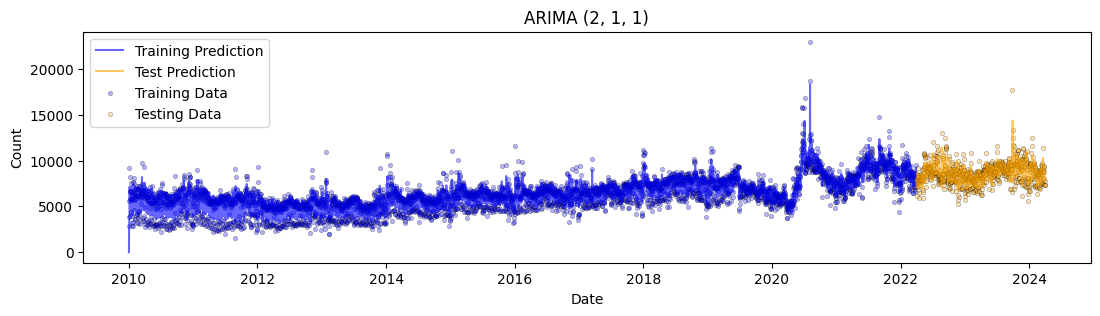

In [44]:
plot_forecast(train_df['Count'], test_df['Count'], arima_211_train_pred, arima_211_predictions, "ARIMA (2, 1, 1)")

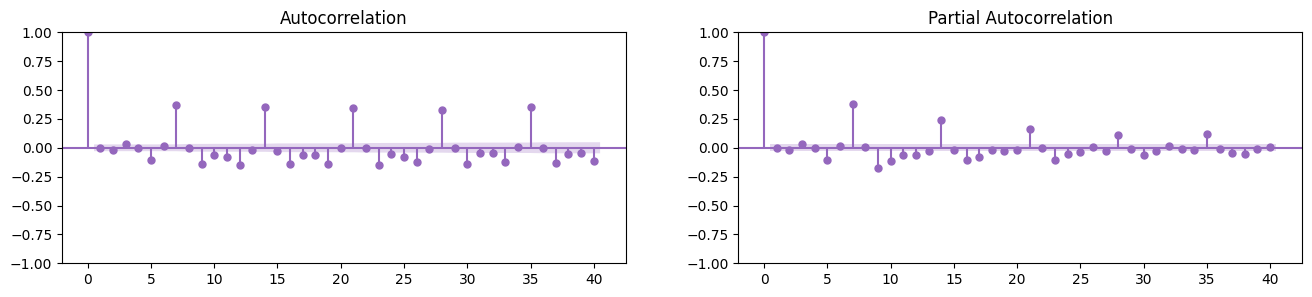

In [168]:
residuals = arima_211_model.resid
fig, axes = plt.subplots(1, 2, figsize=(16, 3))

plot_acf(residuals, lags=40, ax=axes[0])
plot_pacf(residuals, lags=40, ax=axes[1]);

**No real improvement**. At 8.32% MAPE, the lower-order ARIMA model is a bit better than the higher-order ARIMA at 8.34%, and calculates in one third the time.  To reduce complexity, (1,1,1) will remain the current model to beat.  
<br>


### SARIMA for seasonality
The ACF/PACF plots suggested seasonality.  SARIMA is a form of ARIMA model that detects and models seasonality as well (though only one form).  Like ARIMA, SARIMA requires stationary data.  The ADF test showed that undifferenced data taking the seasonal difference

In [169]:
time_series['week_diff'] = time_series['Count_diff'].diff(7)
results_adf_7d = adfuller(time_series['week_diff'].dropna())
print(f'ADF Statistic (1st diff): {results_adf_7d[0]}')
print(f'p-value (1st diff): {results_adf_7d[1]}')

ADF Statistic (1st diff): -21.428598158127986
p-value (1st diff): 0.0


7-day differencing results in stationarity.  'D' term will be 1 as well.

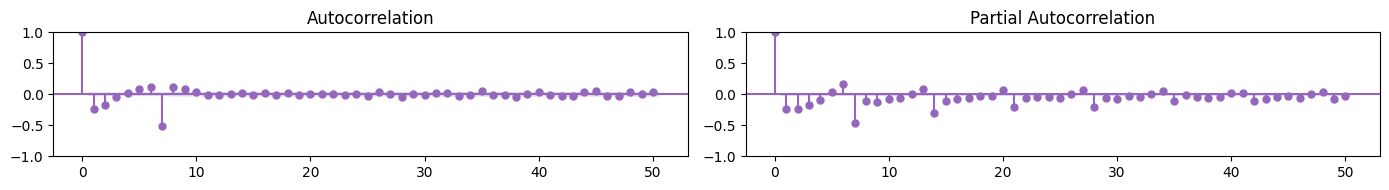

In [170]:
# Plot ACF and PACF of seasonally differenced residuals
fig, ax = plt.subplots(1, 2, figsize=(14, 2))
plot_acf(time_series['week_diff'].dropna(), ax=ax[0], lags=50)
plot_pacf(time_series['week_diff'].dropna(), ax=ax[1], lags=50)
plt.tight_layout()
plt.show()

**MA(Q) = 1**:  The ACF chart rebounds to zero by the second week.  
**AR(P) = 1**:  The PACF chart appears to rebound to zero by the sixth week, which is a very high order.  The P term cannot be determined from this chart.   
<br>
To be conservative, the first SARIMA model will be (1,1,1) (1,1,1) with 7-day seasonality.

In [50]:
sarima_111_1117_mape, sarima_111_1117_train_pred, sarima_111_1117_predictions, sarima_111_1117_model = rolling_forecast(train_df['Count'], test_df['Count'],
                                                                                                                        (1, 1, 1), (1, 1, 1, 7),
                                                                                                                        return_last_model=True)
print(f'MAPE: {sarima_111_1117_mape:.4f}')

C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\R

Progress: 100 out of 731 steps completed in 390.800733089447 seconds


C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\R

Progress: 200 out of 731 steps completed in 402.42355465888977 seconds


C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Progress: 300 out of 731 steps completed in 362.2797086238861 seconds


C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\R

Progress: 400 out of 731 steps completed in 379.86157751083374 seconds


C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Progress: 500 out of 731 steps completed in 359.9300944805145 seconds


C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Progress: 600 out of 731 steps completed in 373.23550176620483 seconds


C:\Users\rickl\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Progress: 700 out of 731 steps completed in 373.6076807975769 seconds
Progress: 731 out of 731 steps completed in 121.69772982597351 seconds
MAPE: 0.0704


In [52]:
sarima_111_1117_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 4473
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -36106.435
Date:                           Fri, 24 May 2024   AIC                          72222.870
Time:                                   15:21:54   BIC                          72254.890
Sample:                                        0   HQIC                         72234.157
                                          - 4473                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5236      0.010     50.860      0.000       0.503       0.544
ma.L1         -0.9435      0.005   -202.548      0.000      -0.953      -0.934
ar.S.L7        0.0595      0.012      4.916      0.000       0.036       0.083
ma.S.L7       -0.9553      0.004   -244.024      0.000      -0.963      -0.948
sigma2      6.166e+05   3596.861    171.440      0.000     6.1e+05    6.24e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):            117054.22
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                             1.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

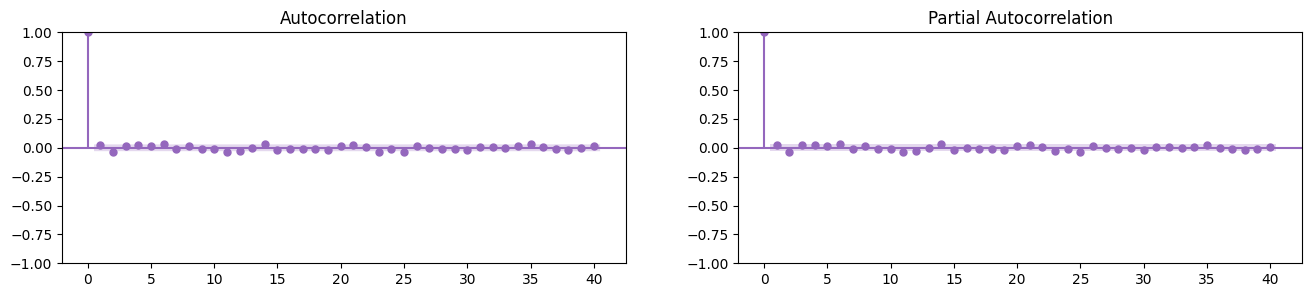

In [55]:
residuals = sarima_111_1117_model.resid

fig, axes = plt.subplots(1, 2, figsize=(16, 3))
plot_acf(residuals, lags=40, ax=axes[0])
plot_pacf(residuals, lags=40, ax=axes[1]);

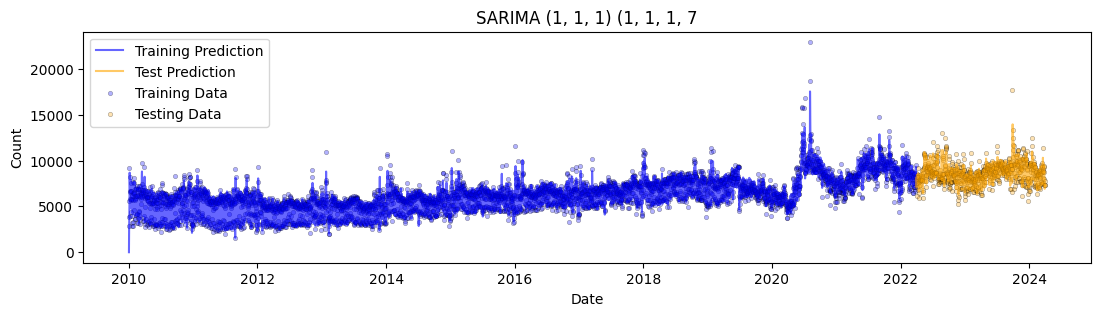

In [57]:
plot_forecast(train_df['Count'], test_df['Count'], sarima_111_1117_train_pred, sarima_111_1117_predictions, "SARIMA (1, 1, 1) (1, 1, 1, 7")

**SARIMA(1,1,1) (1,1,1,7) is superior**. At 7.0%, SARIMA improves substantially on ARIMA.

Last check for better parameters

In [98]:
def fit_sarima_model(train_series: pd.Series, order: tuple[int, int, int], seasonal_order: tuple[int, int, int, int], n_splits: int = 3) -> pd.DataFrame:
    tscv = TimeSeriesSplit(n_splits=n_splits)
    metrics = {
        'Model': f'SARIMA {order}x{seasonal_order}',
        'Log Likelihood': [],
        'AIC': [],
        'BIC': [],
        'HQIC': [],
        'Ljung-Box': [],
        'Jarque-Bera': [],
        'Heteroskedasticity': [],
        'Skew': [],
        'Kurtosis': []
    }
    
    for train_index, test_index in tscv.split(train_series):
        train_fold = train_series.iloc[train_index]
        test_fold = train_series.iloc[test_index]
        
        try:
            model = sm.tsa.statespace.SARIMAX(train_fold, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            
            metrics['Log Likelihood'].append(model_fit.llf)
            metrics['AIC'].append(model_fit.aic)
            metrics['BIC'].append(model_fit.bic)
            metrics['HQIC'].append(model_fit.hqic)
            
            lb_stat, lb_pvalue = sm.stats.acorr_ljungbox(model_fit.resid, lags=[1], return_df=False)
            jb_stat, jb_pvalue, skew, kurtosis = sm.stats.jarque_bera(model_fit.resid)
            het_stat, het_pvalue = sm.stats.het_breuschpagan(model_fit.resid, model_fit.model.exog)
            
            metrics['Ljung-Box'].append(lb_pvalue[0])
            metrics['Jarque-Bera'].append(jb_pvalue)
            metrics['Heteroskedasticity'].append(het_pvalue)
            metrics['Skew'].append(skew)
            metrics['Kurtosis'].append(kurtosis)
        except Exception as e:
            print(f"Model {order}x{seasonal_order} failed on fold {train_index}-{test_index}: {e}")
            continue
    
    avg_metrics = {k: np.mean(v) if isinstance(v, list) else v for k, v in metrics.items()}
    return pd.DataFrame([avg_metrics])

def grid_search_sarima(train_df: pd.DataFrame, feature: str, d: int = 1, D: int = 1, p_range: range = range(0, 3), q_range: range = range(0, 3), P_range: range = range(0, 3), Q_range: range = range(0, 3), m: int = 7) -> pd.DataFrame:
    client = Client('192.168.4.40:8786')
    
    futures = []
    for (p, q, P, Q) in itertools.product(p_range, q_range, P_range, Q_range):
        order = (p, d, q)
        seasonal_order = (P, D, Q, m)
        future = delayed(fit_sarima_model)(train_df[feature], order, seasonal_order)
        futures.append(future)
    
    future_results = client.compute(futures)
    
    results = []
    for future in as_completed(future_results):
        result = future.result()
        results.append(result)
    
    client.close()
    
    results_df = pd.concat(results).reset_index(drop=True)
    return results_df

In [99]:
results_df = grid_search_sarima(train_df, 'Count')
results_df.to_csv('Data/grid_search_results.csv')

In [101]:
exog_cols = [] 
model = SARIMAX(train_df['Count'], order=(1,1,1), seasonal_order=(0,1,2,7))
model_fit = model.fit(disp=False, maxiter=500)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  Count   No. Observations:                 4473
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 7)   Log Likelihood              -35956.166
Date:                                Fri, 24 May 2024   AIC                          71922.332
Time:                                        21:13:25   BIC                          71954.352
Sample:                                    01-01-2010   HQIC                         71933.619
                                         - 03-31-2022                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5257      0.010     50.632      0.000       0.505       0.546
ma.L1         -0.9414      0.005   -197.258      0.000      -0.951      -0.932
ma.S.L7       -0.9046      0.012    -76.505      0.000      -0.928      -0.881
ma.S.L14      -0.0433      0.012     -3.570      0.000      -0.067      -0.020
sigma2      5.756e+05   3369.729    170.813      0.000    5.69e+05    5.82e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.98   Jarque-Bera (JB):            115108.36
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             1.64
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Looks like this one is better, with order of (1,1,1) x (0, 1, 2, 7)

&nbsp;

### SARIMAX  
The SARIMAX model is an extension of the SARIMA model that accounts for exogenous variables.  This calculation will include variables for COVID lockdowns, population, weekends, the introduction of the 311 App, winter months and different weather metrics

The first iteration will include the winning SARIMA model and will add all available exogenous variables.  All variables have been scaled:
- Daily minimum, maximum and average temperatures in Fahrenheit
- Daily rainfall and snowfall in inches
- Daily sunlight in seconds
- Daily wind speed in mph
- Whether the day is a weekend
- Whether there was a COVID lockdown occurring

In [82]:
exog_cols = ['covid', 'rain_sum', 'temperature_2m_min', 'wind_speed_10m_max', 'daylight_duration', 'temperature_2m_mean'] 
model = SARIMAX(train_df['Count'], train_df[exog_cols], order=(1,1,1), seasonal_order=(1,1,1,7))
model_fit = model.fit(disp=False, maxiter=500)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Count   No. Observations:                 4473
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -35839.682
Date:                           Fri, 24 May 2024   AIC                          71701.364
Time:                                   18:40:40   BIC                          71771.808
Sample:                               01-01-2010   HQIC                         71726.195
                                    - 03-31-2022                                         
Covariance Type:                             opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
covid                -420.6041    131.870     -3.190      0.001    -679.065    -162.143
rain_sum               -8.1612      1.363     -5.990      0.000     -10.832      -5.491
temperature_2m_min   -101.4405     30.871     -3.286      0.001    -161.947     -40.934
wind_speed_10m_max    161.6836     36.765      4.398      0.000      89.625     233.742
daylight_duration     826.1255    305.659      2.703      0.007     227.044    1425.207
temperature_2m_mean   -47.6936     27.976     -1.705      0.088    -102.526       7.139
ar.L1                   0.5052      0.011     46.573      0.000       0.484       0.526
ma.L1                  -0.9378      0.005   -178.603      0.000      -0.948      -0.927
ar.S.L7                 0.0444      0.013      3.336      0.001       0.018       0.070
ma.S.L7                -0.9503      0.004   -230.772      0.000      -0.958      -0.942
sigma2               5.461e+05   4089.207    133.546      0.000    5.38e+05    5.54e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.28   Jarque-Bera (JB):            125253.28
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                             1.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
exog_cols = ['covid', 'rain_sum', 'temperature_2m_min', 'wind_speed_10m_max', 'daylight_duration', 'temperature_2m_mean'] 

sarimax_ex_mape, sarimax_ex_train_pred, sarimax_ex_predictions, sarimax_model = rolling_forecast(train_df['Count'], test_df['Count'],
                                                                                                 (1,1,1), (1,1,1,7),
                                                                                                 train_df[exog_cols], test_df[exog_cols],
                                                                                                 maxiter=500, return_last_model=True)
print(f"MAPE: {sarimax_ex_mape}")

Progress: 100 out of 731 steps completed in 1016.8650686740875 seconds
Progress: 200 out of 731 steps completed in 1000.2391195297241 seconds
Progress: 300 out of 731 steps completed in 971.7462155818939 seconds
Progress: 400 out of 731 steps completed in 1052.8070712089539 seconds
Progress: 500 out of 731 steps completed in 1062.052963733673 seconds
Progress: 600 out of 731 steps completed in 1037.6436688899994 seconds
Progress: 700 out of 731 steps completed in 1067.2879543304443 seconds
Progress: 731 out of 731 steps completed in 315.9559690952301 seconds
MAPE: 0.06927899847576584


In [84]:
sarimax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 4473
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -35988.759
Date:                           Fri, 24 May 2024   AIC                          71999.519
Time:                                   20:46:16   BIC                          72069.963
Sample:                                        0   HQIC                         72024.350
                                          - 4473                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -406.9409    141.630     -2.873      0.004    -684.532    -129.350
x2           -10.7450      1.387     -7.746      0.000     -13.464      -8.026
x3          -113.6743     31.278     -3.634      0.000    -174.978     -52.370
x4           128.3879     38.777      3.311      0.001      52.386     204.390
x5           416.0846    292.870      1.421      0.155    -157.930     990.099
x6           -13.4363     28.098     -0.478      0.633     -68.508      41.635
ar.L1          0.5120      0.010     49.159      0.000       0.492       0.532
ma.L1         -0.9434      0.005   -199.305      0.000      -0.953      -0.934
ar.S.L7        0.0596      0.012      4.772      0.000       0.035       0.084
ma.S.L7       -0.9556      0.004   -245.961      0.000      -0.963      -0.948
sigma2      5.848e+05   4297.855    136.058      0.000    5.76e+05    5.93e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):            136914.22
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                             1.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

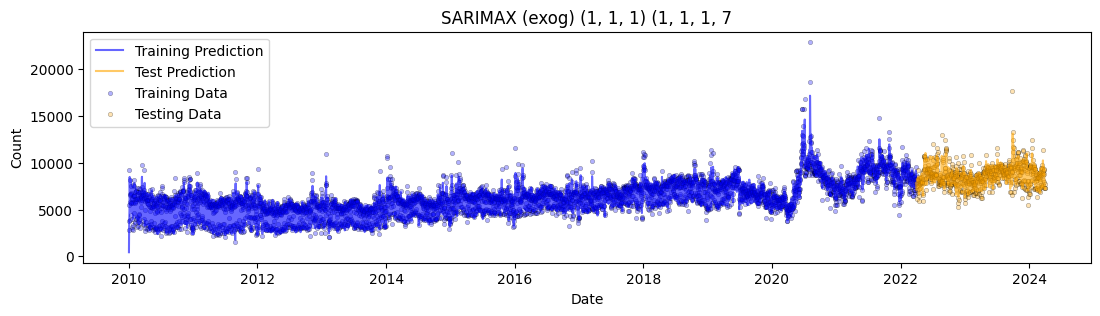

In [87]:
plot_forecast(train_df['Count'], test_df['Count'], sarimax_ex_train_pred, sarimax_ex_predictions, "SARIMAX (exog) (1, 1, 1) (1, 1, 1, 7")

<br>

### Prophet
- Switch to using Facebook's Prophet model
- Capable of analyzing multiple seasonalities
- Can take in exogenous variables
- Can take into account holidays and one time events, such as COVID lockdowns

In [182]:
df_311_encoded = pd.get_dummies(df_311_calls, columns=['Agency']).drop(columns=['Type','Zip','Borough'],axis=1)
#df_311_encoded.head()
time_series_encoded = df_311_encoded.groupby('Date').sum()

Agency_Buildings  Agency_Consumer  Agency_Environment  \
Date                                                                
2010-01-01                57               11                 143   
2010-01-02                91               10                 168   
2010-01-03                90               12                 175   
2010-01-04               438               36                 425   
2010-01-05               451               59                 492   

            Agency_Finance  Agency_Homeless  Agency_Housing  \
Date                                                          
2010-01-01               8                4            1278   
2010-01-02               4                0            2276   
2010-01-03               6                0            3771   
2010-01-04             431              186            5127   
2010-01-05             294              173            4097   

            Agency_Human Resources  Agency_Other  Agency_Parks  Agency_Police  \
Date                                                                            
2010-01-01                       0            32            29            922   
2010-01-02                       0            67            38            632   
2010-01-03                       0            88            25            423   
2010-01-04                       0           273            90            533   
2010-01-05                       0           213            91            537   

            Agency_Sanitation  Agency_Taxi  Agency_Transportation  
Date                                                               
2010-01-01                130           76                    162  
2010-01-02                192           44                    306  
2010-01-03                540           35                    374  
2010-01-04                807           56                    818  
2010-01-05                785           49                    935

In [189]:
prophet_df = pd.concat([time_series, time_series_encoded], axis=1).drop(columns=['Count_diff','week_diff'],axis=1)

In [190]:
columns_to_sum = ['Agency_Consumer','Agency_Finance','Agency_Homeless','Agency_Human Resources','Agency_Other','Agency_Taxi']
prophet_df['Agency_Misc'] = prophet_df[columns_to_sum].sum(axis=1)
prophet_df.drop(columns=columns_to_sum, inplace=True)

Count  covid  winter  weekend  311_app  temperature_2m_max  \
2010-01-01   2852      0       1        0        0            0.175818   
2010-01-02   3828      0       1        1        0           -1.375657   
2010-01-03   5539      0       1        1        0           -2.189736   
2010-01-04   9220      0       1        0        0           -1.001858   
2010-01-05   8176      0       1        0        0           -1.339170   

            temperature_2m_min  temperature_2m_mean  daylight_duration  \
2010-01-01           -0.667740            -0.294884           0.011686   
2010-01-02           -2.075379            -1.380453           0.013809   
2010-01-03           -2.108758            -2.462976           0.016103   
2010-01-04           -0.838221            -1.217928           0.018563   
2010-01-05           -1.280739            -1.694560           0.021189   

             rain_sum  ...  wind_speed_10m_max  population  Agency_Buildings  \
2010-01-01  -5.086032  ...            1.872807    0.000000                57   
2010-01-02  -6.568085  ...            2.729425    0.000132                91   
2010-01-03 -21.517231  ...            2.970008    0.000265                90   
2010-01-04 -21.517231  ...            2.462322    0.000397               438   
2010-01-05 -21.517231  ...            2.330225    0.000530               451   

            Agency_Environment  Agency_Housing  Agency_Parks  Agency_Police  \
2010-01-01                 143            1278            29            922   
2010-01-02                 168            2276            38            632   
2010-01-03                 175            3771            25            423   
2010-01-04                 425            5127            90            533   
2010-01-05                 492            4097            91            537   

            Agency_Sanitation  Agency_Transportation  Agency_Misc  
2010-01-01                130                    162          131  
2010-01-02                192                    306          125  
2010-01-03                540                    374          141  
2010-01-04                807                    818          982  
2010-01-05                785                    935          788  

[5 rows x 21 columns]

In [192]:
test_size = 731         # two years plus one day

split_point = len(prophet_df) - test_size
prophet_train = prophet_df.iloc[:split_point]
prophet_test = prophet_df.iloc[split_point:]

In [198]:
def create_prophet_model(train_series: pd.Series, weekly: bool, monthly: bool, yearly: bool, holidays: pd.DataFrame) -> Prophet:
    model = Prophet(yearly_seasonality=yearly, weekly_seasonality=weekly, holidays=holidays)
    
    if monthly:
        model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    
    return model

def evaluate_prophet_model(weekly: bool, monthly: bool, yearly: bool, train_series: pd.Series, holidays: pd.DataFrame, horizon: str) -> tuple:
    model = create_prophet_model(train_series, weekly, monthly, yearly, holidays)
    df = train_series.reset_index().rename(columns={'index': 'ds', train_series.name: 'y'})
    model.fit(df)
    
    initial = '730 days'  # Start with one annual cycle
    period = '180 days'
    
    df_cv = cross_validation(model, initial=initial, period=period, horizon=horizon)
    df_p = performance_metrics(df_cv)
    
    mape = df_p['mape'].mean()
    return mape, model

def grid_search_prophet(train_df: pd.DataFrame, feature: str, holidays: pd.DataFrame) -> tuple:
    seasonality_options = [True, False]
    best_mape = np.inf
    best_config = None
    best_model = None
    
    client = Client('192.168.4.40:8786')
    futures = []
    
    for weekly, monthly, yearly in itertools.product(seasonality_options, repeat=3):
        future = delayed(evaluate_prophet_model)(weekly, monthly, yearly, train_df[feature], holidays, horizon='730 days')
        futures.append(future)

    futures = client.compute(futures)
    
    for future in as_completed(futures):
        try:
            mape, fitted_model = future.result()
            if mape < best_mape:
                best_mape = mape
                best_config = (weekly, monthly, yearly)
                best_model = fitted_model
        except ValueError as e:
            print(f"Skipping configuration due to error: {e}")
    
    client.close()
    
    if best_model is not None:
        # Final validation with 1-day horizon
        final_mape, final_model = evaluate_prophet_model(best_config[0], best_config[1], best_config[2], train_df[feature], holidays, horizon='1 day')
    else:
        final_mape, final_model = np.inf, None
    
    return best_config, final_mape, final_model

In [199]:
# Create and concatenate all holidays into a single variable

# Add US holidays
us_holidays = make_holidays_df(year_list=range(2010, 2025), country='US')

# Create a special COVID lockdown "holiday" category
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days

# NYC-specific events
nyc_marathon = pd.DataFrame({
    'holiday': 'NYC Marathon',
    'ds': pd.to_datetime(['2010-11-07','2011-11-06','2013-11-03','2014-11-02','2015-11-01','2016-11-06',
                          '2017-11-05','2018-11-04','2019-11-03','2021-11-07','2022-11-06','2023-11-05']),
    'lower_window': 0,
    'upper_window': 1,
})

nyc_storms = pd.DataFrame({
    'holiday': 'NYC Storms',
    'ds': pd.to_datetime(['2011-08-27','2011-08-28','2011-08-29','2011-10-29','2011-10-30','2011-10-31',
                          '2016-01-22','2016-01-23','2016-01-24','2016-01-25','2020-08-04','2020-08-05']),
    'lower_window': 0,
    'upper_window': 1,
})

holidays = pd.concat([us_holidays, nyc_marathon, nyc_storms, lockdowns])

In [200]:
# Example usage
best_config, best_mape, best_model = grid_search_prophet(prophet_train, 'Agency_Police', holidays)

print(f'Best Configuration: Weekly={best_config[0]}, Monthly={best_config[1]}, Yearly={best_config[2]}')
print(f'Best MAPE: {best_mape}')


22:38:04 - cmdstanpy - INFO - Chain [1] start processing
22:38:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/21 [00:00<?, ?it/s]

22:38:04 - cmdstanpy - INFO - Chain [1] start processing
22:38:04 - cmdstanpy - INFO - Chain [1] done processing
22:38:05 - cmdstanpy - INFO - Chain [1] start processing
22:38:05 - cmdstanpy - INFO - Chain [1] done processing
22:38:05 - cmdstanpy - INFO - Chain [1] start processing
22:38:05 - cmdstanpy - INFO - Chain [1] done processing
22:38:06 - cmdstanpy - INFO - Chain [1] start processing
22:38:06 - cmdstanpy - INFO - Chain [1] done processing
22:38:06 - cmdstanpy - INFO - Chain [1] start processing
22:38:06 - cmdstanpy - INFO - Chain [1] done processing
22:38:07 - cmdstanpy - INFO - Chain [1] start processing
22:38:07 - cmdstanpy - INFO - Chain [1] done processing
22:38:07 - cmdstanpy - INFO - Chain [1] start processing
22:38:08 - cmdstanpy - INFO - Chain [1] done processing
22:38:08 - cmdstanpy - INFO - Chain [1] start processing
22:38:08 - cmdstanpy - INFO - Chain [1] done processing
22:38:09 - cmdstanpy - INFO - Chain [1] start processing
22:38:09 - cmdstanpy - INFO - Chain [1]

Best Configuration: Weekly=False, Monthly=False, Yearly=False
Best MAPE: 0.20497383398055335


In [132]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, holidays=holidays)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
df = train_df['Count'].reset_index().rename(columns={'index': 'ds', train_df['Count'].name: 'y'})
model.fit(df)

21:57:34 - cmdstanpy - INFO - Chain [1] start processing
21:57:35 - cmdstanpy - INFO - Chain [1] done processing


In [226]:
train_df_temp = train_df.reset_index().rename(columns={'index': 'ds'})
regressors_df = train_df_temp[['ds', '311_app', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'daylight_duration', 'rain_sum', 'snowfall_sum', 'wind_speed_10m_max', 'population']]

In [234]:
feature = 'Agency_Parks'
df = prophet_train[[feature]].reset_index().rename(columns={'index': 'ds', feature: 'y'})
df = df.merge(regressors_df, on='ds', how='left')

model = Prophet(yearly_seasonality=True, weekly_seasonality=False, holidays=holidays)
#model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

for regressor in regressors_df.columns.difference(['ds']):
    model.add_regressor(regressor)

model.fit(df)
forecast = model.predict(df)

y_true = df['y'].values
y_pred = forecast['yhat'].values

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f'MAPE: {mape}')

23:09:02 - cmdstanpy - INFO - Chain [1] start processing
23:09:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 0.44613270568348024


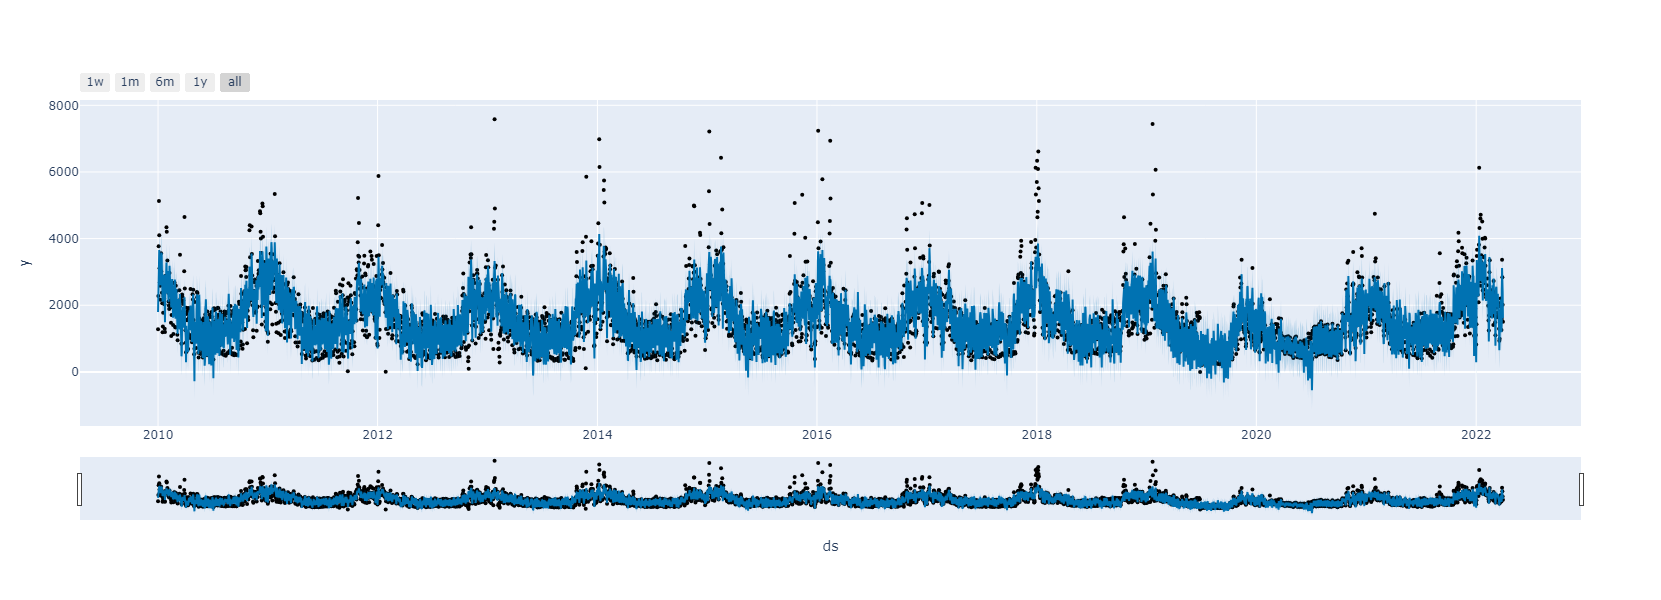

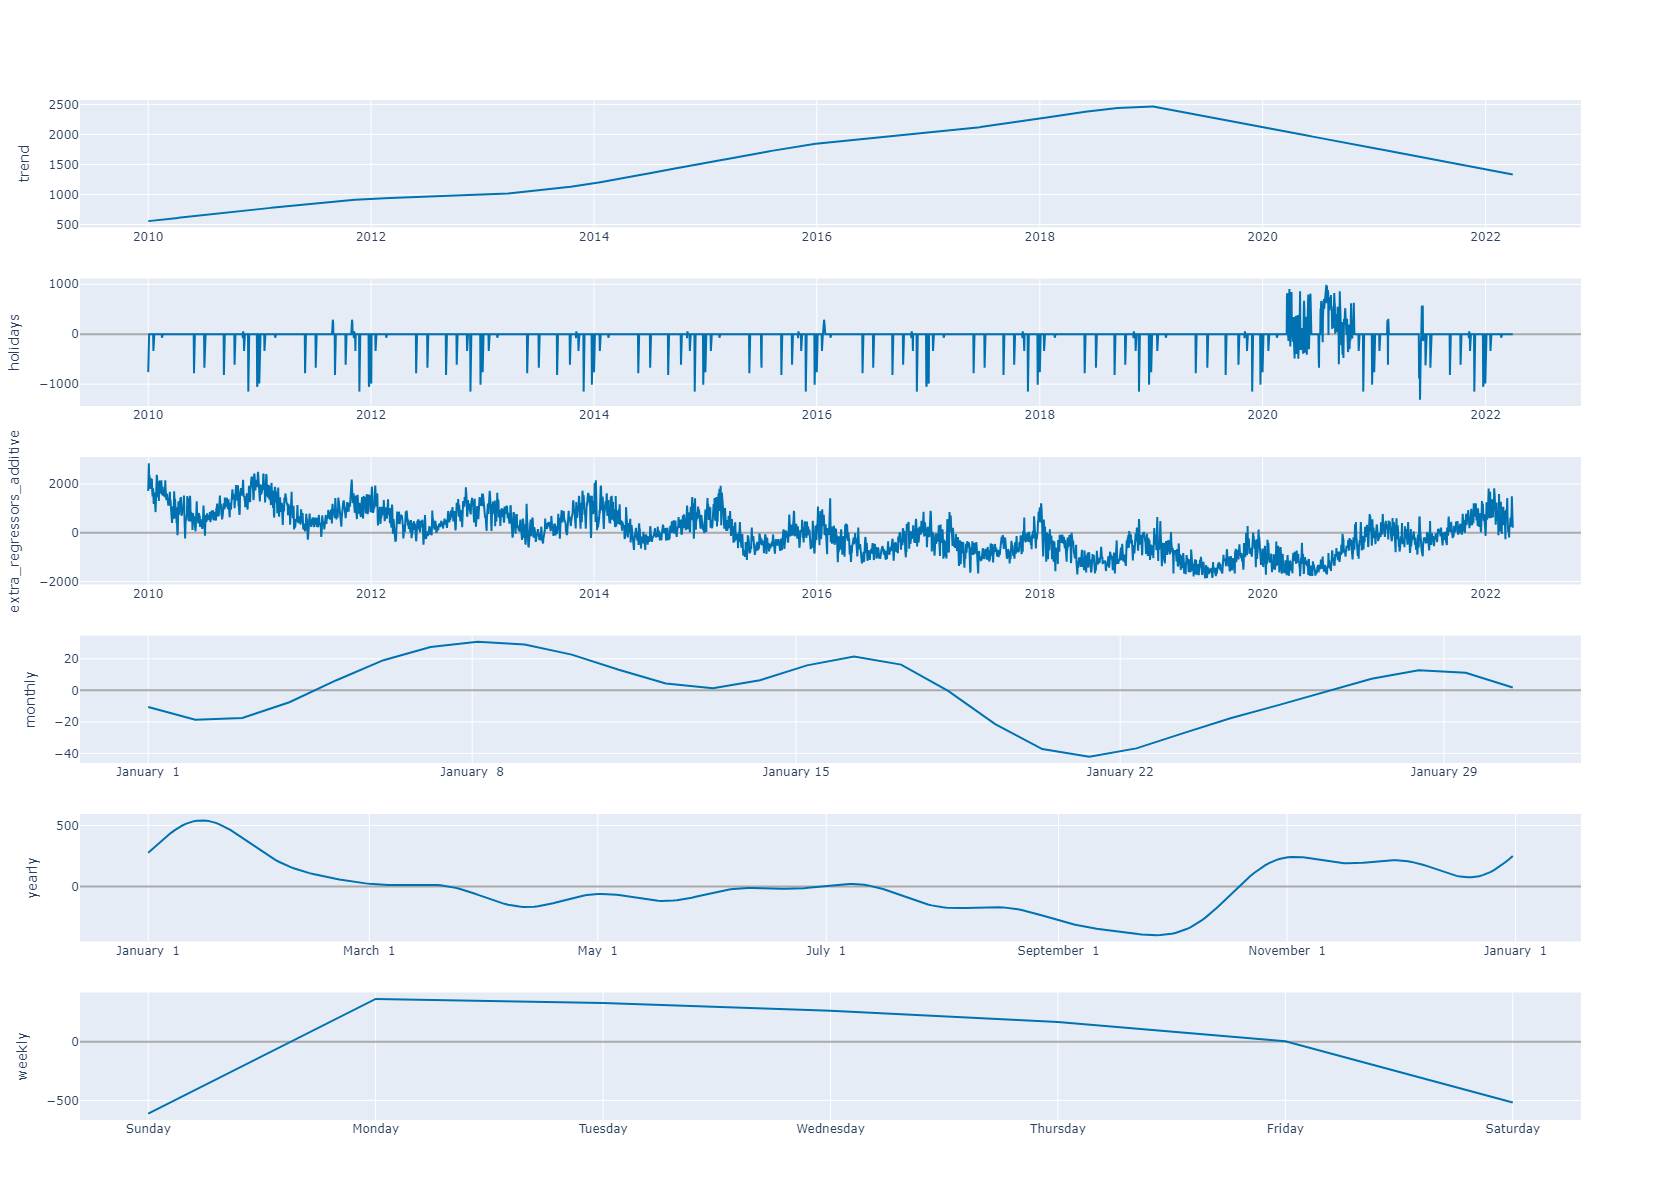

In [230]:
from prophet.plot import plot_plotly, plot_components_plotly

# Plot the forecast
fig = plot_plotly(model, forecast)
fig.show()

# Plot the forecast components
fig_components = plot_components_plotly(model, forecast)
fig_components.show()

### GARCH

In [240]:
train_df.drop('Count',axis=1).head()

covid  winter  weekend  311_app  temperature_2m_max  \
2010-01-01      0       1        0        0            0.175818   
2010-01-02      0       1        1        0           -1.375657   
2010-01-03      0       1        1        0           -2.189736   
2010-01-04      0       1        0        0           -1.001858   
2010-01-05      0       1        0        0           -1.339170   

            temperature_2m_min  temperature_2m_mean  daylight_duration  \
2010-01-01           -0.667740            -0.294884           0.011686   
2010-01-02           -2.075379            -1.380453           0.013809   
2010-01-03           -2.108758            -2.462976           0.016103   
2010-01-04           -0.838221            -1.217928           0.018563   
2010-01-05           -1.280739            -1.694560           0.021189   

             rain_sum  snowfall_sum  wind_speed_10m_max  population  
2010-01-01  -5.086032 -1.473707e+00            1.872807    0.000000  
2010-01-02  -6.568085 -2.786367e+00            2.729425    0.000132  
2010-01-03 -21.517231 -9.017416e+00            2.970008    0.000265  
2010-01-04 -21.517231 -2.600800e+06            2.462322    0.000397  
2010-01-05 -21.517231 -2.600800e+06            2.330225    0.000530

In [260]:
train_df.columns

Index(['Count', 'covid', 'winter', 'weekend', '311_app', 'temperature_2m_max',
       'temperature_2m_min', 'temperature_2m_mean', 'daylight_duration',
       'rain_sum', 'snowfall_sum', 'wind_speed_10m_max', 'population'],
      dtype='object')

In [324]:
# ARCH performs better with values of 1-1000
scaled_y = train_df[['Count']]/1000

# External regressors
exog_cols = ['covid','weekend','311_app','temperature_2m_mean','daylight_duration','population','rain_sum','wind_speed_10m_max']
exog_train = train_df[exog_cols]

# Fit GARCH(1,1) model with external regressors
garch_model = arch_model(scaled_y, vol='Garch', p=1, q=1, mean='ARX', lags=1, x=exog_train)
garch_fit = garch_model.fit()

# Summary of the model
garch_fit.summary()

Iteration:      1,   Func. Count:     15,   Neg. LLF: 825112460.0966469
Iteration:      2,   Func. Count:     38,   Neg. LLF: 76121148114.17668
Iteration:      3,   Func. Count:     60,   Neg. LLF: 24091993.965163864
Iteration:      4,   Func. Count:     78,   Neg. LLF: 2498033980716.0596
Iteration:      5,   Func. Count:     96,   Neg. LLF: 17527775650055.824
Iteration:      6,   Func. Count:    113,   Neg. LLF: 662793382307.9941
Iteration:      7,   Func. Count:    129,   Neg. LLF: 60944.77265073551
Iteration:      8,   Func. Count:    148,   Neg. LLF: 3589346306712.7217
Iteration:      9,   Func. Count:    165,   Neg. LLF: 46744.420917773605
Iteration:     10,   Func. Count:    182,   Neg. LLF: 16635.236922489494
Iteration:     11,   Func. Count:    199,   Neg. LLF: 20962.433069130777
Iteration:     12,   Func. Count:    215,   Neg. LLF: 20240456.3330104
Iteration:     13,   Func. Count:    232,   Neg. LLF: 5925.903303513167
Iteration:     14,   Func. Count:    246,   Neg. LLF: 3070

<class 'statsmodels.iolib.summary.Summary'>
"""
                          AR-X - GARCH Model Results                          
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.654
Mean Model:                      AR-X   Adj. R-squared:                  0.653
Vol Model:                      GARCH   Log-Likelihood:               -5915.06
Distribution:                  Normal   AIC:                           11856.1
Method:            Maximum Likelihood   BIC:                           11939.4
                                        No. Observations:                 4472
Date:                Sat, May 25 2024   Df Residuals:                     4462
Time:                        01:47:16   Df Model:                           10
                                       Mean Model                                       
========================================================================================
                           coef    std err          t      P>|t|        95.0% Conf. Int.
----------------------------------------------------------------------------------------
Const                    1.9801      0.161     12.308  8.213e-35       [  1.665,  2.295]
Count[1]                 0.4383  2.222e-02     19.730  1.199e-86       [  0.395,  0.482]
covid                    1.3252      0.504      2.632  8.494e-03       [  0.338,  2.312]
weekend                 -1.3747  3.614e-02    -38.040      0.000       [ -1.446, -1.304]
311_app              1.9443e-03  7.012e-02  2.773e-02      0.978       [ -0.135,  0.139]
temperature_2m_mean     -0.0977  1.529e-02     -6.391  1.652e-10    [ -0.128,-6.773e-02]
daylight_duration    8.5960e-03  5.031e-02      0.171      0.864    [-9.000e-02,  0.107]
population               1.4918      0.158      9.426  4.254e-21       [  1.182,  1.802]
rain_sum            -7.0819e-03  1.356e-03     -5.224  1.747e-07 [-9.739e-03,-4.425e-03]
wind_speed_10m_max       0.3870  4.565e-02      8.478  2.296e-17       [  0.298,  0.476]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      9.3753e-03  3.534e-03      2.653  7.989e-03 [2.448e-03,1.630e-02]
alpha[1]       0.0526  1.054e-02      4.994  5.908e-07 [3.198e-02,7.329e-02]
beta[1]        0.9378  1.256e-02     74.640      0.000     [  0.913,  0.962]
============================================================================

Covariance estimator: robust
"""

In [325]:
# Prepare the test data
scaled_test_y = test_df[['Count']] / 1000
exog_test = test_df[exog_cols].values

# Initialize arrays for predictions and actual values
predictions = []
actuals = scaled_test_y.values.flatten()

# Perform rolling forecasts
for i in range(len(test_df)):
    # Extend the training set with each new observation from the test set
    extended_train_y = np.concatenate([scaled_y.values.flatten(), scaled_test_y.values[:i+1].flatten()])
    extended_exog = np.concatenate([exog_train.values, exog_test[:i+1]], axis=0)
    
    # Refit the model with the extended data
    rolling_garch_model = arch_model(extended_train_y, vol='Garch', p=1, q=2, mean='ARX', lags=4, x=extended_exog)
    rolling_garch_fit = rolling_garch_model.fit(disp="off")
    
    # Forecast the next day
    forecast_exog = exog_test[i].reshape((len(exog_cols), 1, 1))
    forecast = rolling_garch_fit.forecast(horizon=1, x=forecast_exog)
    predictions.append(forecast.mean.iloc[-1].values[0])

# Rescale the predictions back to the original scale
predictions = np.array(predictions) * 1000

# Calculate actual values in the original scale
actuals = test_df['Count'].values

# Evaluate performance using MAPE
mape = mean_absolute_percentage_error(actuals, predictions)

print(f'Mean Absolute Percentage Error (MAPE): {mape}')

Mean Absolute Percentage Error (MAPE): 0.07533345561239843


In [333]:
# ARCH performs better with values of 1-1000
scaled_y = train_df[['Count']] *.1

# External regressors
exog_cols = ['covid', 'weekend', '311_app', 'temperature_2m_mean', 'daylight_duration', 'population', 'rain_sum', 'wind_speed_10m_max']
exog_train = train_df[exog_cols]

# Initialize arrays for predictions and actual values
train_preds = []
actuals = scaled_y.values.flatten()

# Set the number of lags and minimum observations
n_lags = 1
min_obs = 11  # Minimum observations to fit the model

# Perform rolling forecasts
for i in range(min_obs, len(train_df)):
    # Use all available data up to the current day to fit the model
    rolling_train_y = scaled_y.values[:i]
    rolling_exog = exog_train.values[:i]
    
    # Fit the model with the rolling data
    rolling_garch_model = arch_model(rolling_train_y, vol='Garch', p=1, q=1, mean='ARX', lags=n_lags, x=rolling_exog)
    rolling_garch_fit = rolling_garch_model.fit(disp="off")
    
    # Forecast the next day
    forecast_exog = exog_train.values[i].reshape((len(exog_cols), 1, 1))
    forecast = rolling_garch_fit.forecast(horizon=1, x=forecast_exog)
    train_preds.append(forecast.mean.iloc[-1].values[0])

# Rescale the predictions back to the original scale
train_preds = np.array(train_preds) / .1

# Calculate actual values in the original scale
actuals = train_df['Count'].values[min_obs:]  # Skip the first min_obs values as we cannot predict them

# Evaluate performance using MAPE
mape = mean_absolute_percentage_error(actuals, train_preds)

print(f'Mean Absolute Percentage Error (MAPE): {mape}')

Mean Absolute Percentage Error (MAPE): 0.1275593579937211


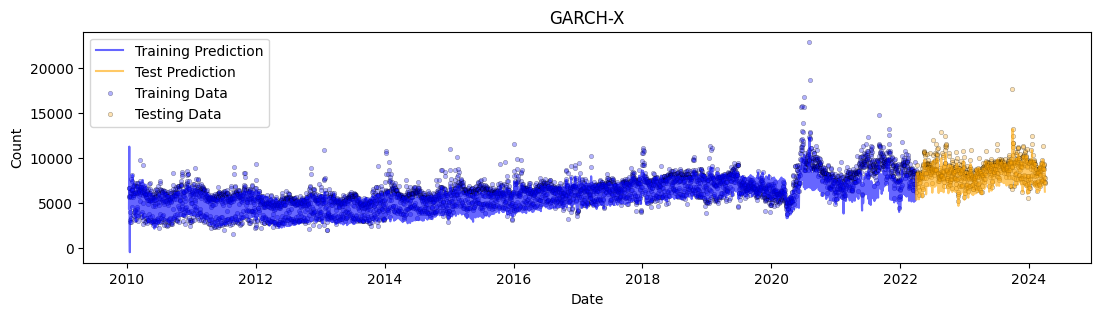

In [336]:
plot_forecast(train_df['Count'][11:], test_df['Count'], train_preds, predictions, "GARCH-X")

&nbsp;

### LTSM

In [ ]:
time_series.columns

In [ ]:
features_to_drop = ['Count', 'covid', 'winter', 'wind_speed_10m_max', 'population']

# Assuming 'time_series' is your DataFrame
df = time_series.drop(columns=['Count_diff', 'week_diff'], axis=1).copy()

# Ensure the DataFrame is sorted by date
df = df.sort_index()

# Separate features and target
features = df.drop(columns=features_to_drop)
target = df[['Count']]

# Scale the target using MinMaxScaler
target_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = target_scaler.fit_transform(target)

# Combine scaled features and scaled target for sequence creation
scaled_data = np.concatenate((scaled_target, features.values), axis=1)

# Function to create sequences
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 1:])  # All columns except the target for input
        y.append(data[i + time_steps, 0])  # Target column for output
    return np.array(X), np.array(y)

time_steps = 28  # Number of time steps to look back
X, y = create_sequences(scaled_data, time_steps)

# Reshape X to be [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split into training and testing data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build a hybrid CNN-LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(time_steps, X.shape[2])))
lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
lstm_model.add(MaxPooling1D(pool_size=2))
lstm_model.add(Bidirectional(GRU(50, return_sequences=True, kernel_regularizer=l2(0.01))))
lstm_model.add(Dropout(0.4))
lstm_model.add(Bidirectional(GRU(50, return_sequences=False, kernel_regularizer=l2(0.01))))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(25, kernel_regularizer=l2(0.01)))
lstm_model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
lstm_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
lstm_model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=100, callbacks=[early_stopping])

# Predict and invert the scaling
train_predictions = lstm_model.predict(X_train)
test_predictions = lstm_model.predict(X_test)

train_predictions = target_scaler.inverse_transform(train_predictions)
test_predictions = target_scaler.inverse_transform(test_predictions)

# Inverse transform y_train and y_test for comparison
train_actual = target_scaler.inverse_transform(y_train.reshape(-1, 1))
test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
train_lstm_mape = mean_absolute_percentage_error(train_actual, train_predictions)
test_lstm_mape = mean_absolute_percentage_error(test_actual, test_predictions)


print('LSTM model errors')
print('-------------------------')
print(f'Train MAPE: {train_lstm_mape:.4f}')
print('-------------------------')
print(f'Test MAPE: {test_lstm_mape:.4f}')


In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df.index[time_steps:split + time_steps], train_actual, label='Train Actual')
plt.plot(df.index[time_steps:split + time_steps], train_predictions, label='Train Predictions', linestyle='--')
plt.plot(df.index[split + time_steps:], test_actual, label='Test Actual')
plt.plot(df.index[split + time_steps:], test_predictions, label='Test Predictions', linestyle='--')
plt.legend()
plt.show()